# Physics analysis on a GPU!

Joosep Pata (NICPB, Estonia)

firstname.lastname@cern.ch

In this notebook, we'll show how to connect `uproot`, `awkward-array`, `cupy` and `numba` to do numerically intensive physics data processing such as histogramming directly on a GPU!


This is an entry-level tutorial, we don't focus on highly technical GPU optimizations at this time. It's mostly based on work that happened prior to the latest exciting developments (`awkward1`, `NanoEvents`, ...) in the PyHEP world, some of which we have already seen today.

In [5]:
#switch to a GPU runtime, let's check which GPU we got

In [6]:
!nvidia-smi

Mon Jul 13 15:23:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Let's download an opendata ntuple for local use.

In [7]:
!wget -nc http://jpata.web.cern.ch/jpata/opendata_files/DYJetsToLL-merged/1.root

--2020-07-13 15:24:15--  http://jpata.web.cern.ch/jpata/opendata_files/DYJetsToLL-merged/1.root
Resolving jpata.web.cern.ch (jpata.web.cern.ch)... 188.185.67.197, 2001:1458:d00:1::100:3bf
Connecting to jpata.web.cern.ch (jpata.web.cern.ch)|188.185.67.197|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1400675064 (1.3G) [text/plain]
Saving to: ‘1.root’

1.root              100%[===================>]   1.30G  6.12MB/s    in 5m 44s  

2020-07-13 15:29:59 (3.88 MB/s) - ‘1.root’ saved [1400675064/1400675064]



While the file is downloading, here's an overview of what we'll be doing.

1. Load a file with uproot, get the awkward array content
2. Compile a custom CUDA kernel with numba
3. Process an array with with threads in a kernel
3. Create a kernel to process jagged array events
4. Compute the invariant mass of jets in an event on the GPU and fill a weighted histogram
5. ADL exercise 7: mask jets with respect to leptons with dR, compute jet sum pt and fill into a histogram

In CUDA, we execute functions (kernels) in many simultaneous threads. Each thread is indexed by a block and thread index and gets assigned a chunk of work based on this index. Threads in the same block run in lock step on the same GPU core (SM), each of which consists of many CUDA cores.

![CUDA thread grid](http://cuda.ce.rit.edu/cuda_overview/clip_image004.jpg)

In [8]:
!pip install uproot uproot-methods awkward1 xxhash lz4 wurlitzer mplhep

     |████████████████████████████████| 122kB 7.8MB/s 
     |████████████████████████████████| 8.2MB 9.5MB/s 
     |████████████████████████████████| 225kB 49.9MB/s 
     |████████████████████████████████| 1.8MB 49.7MB/s 
     |████████████████████████████████| 5.4MB 47.5MB/s 
     |████████████████████████████████| 92kB 11.9MB/s 


In [9]:
# capture stdout directly, as it is not piped to jupyter otherwise
# https://github.com/jupyterhub/jupyterhub/issues/2035

from wurlitzer import pipes

def run_and_print(function, *args):
  with pipes() as (out, err):
    function(*args)
  stdout = out.read()
  print(stdout)

# 1. Load ROOT files with uproot

In [10]:
import uproot
fi = uproot.open("1.root")

evs = fi["Events"]
evs.keys()

[b'run',
 b'luminosityBlock',
 b'event',
 b'HLT_IsoMu24_eta2p1',
 b'HLT_IsoMu24',
 b'HLT_IsoMu17_eta2p1_LooseIsoPFTau20',
 b'PV_npvs',
 b'PV_x',
 b'PV_y',
 b'PV_z',
 b'nMuon',
 b'Muon_pt',
 b'Muon_eta',
 b'Muon_phi',
 b'Muon_mass',
 b'Muon_charge',
 b'Muon_pfRelIso03_all',
 b'Muon_pfRelIso04_all',
 b'Muon_tightId',
 b'Muon_softId',
 b'Muon_dxy',
 b'Muon_dxyErr',
 b'Muon_dz',
 b'Muon_dzErr',
 b'Muon_jetIdx',
 b'Muon_genPartIdx',
 b'nElectron',
 b'Electron_pt',
 b'Electron_eta',
 b'Electron_phi',
 b'Electron_mass',
 b'Electron_charge',
 b'Electron_pfRelIso03_all',
 b'Electron_dxy',
 b'Electron_dxyErr',
 b'Electron_dz',
 b'Electron_dzErr',
 b'Electron_cutBasedId',
 b'Electron_pfId',
 b'Electron_jetIdx',
 b'Electron_genPartIdx',
 b'nTau',
 b'Tau_pt',
 b'Tau_eta',
 b'Tau_phi',
 b'Tau_mass',
 b'Tau_charge',
 b'Tau_decayMode',
 b'Tau_relIso_all',
 b'Tau_jetIdx',
 b'Tau_genPartIdx',
 b'Tau_idDecayMode',
 b'Tau_idIsoRaw',
 b'Tau_idIsoVLoose',
 b'Tau_idIsoLoose',
 b'Tau_idIsoMedium',
 b'Tau_idIs

In [12]:
jet_pt = evs.array("Jet_pt")
jet_eta = evs.array("Jet_eta")
jet_phi = evs.array("Jet_phi")
jet_mass = evs.array("Jet_mass")
jet_pt

<JaggedArray [[36.25315 32.198524 30.101957 ... 16.848015 15.487583 15.025305] [23.939432 21.36061 20.008955 ... 16.034006 15.96491 15.766194] [] ... [39.726204 26.98962 18.819519 17.05436 16.62841 16.533186] [23.370874] [31.095316 28.646101 25.23673 ... 18.90005 17.481096 15.94793]] at 0x7f8a420c0f60>

# 2. Create an example kernel

In [13]:
import numpy as np
import numba
import cupy
from numba import cuda
import math

import mplhep
import matplotlib.pyplot as plt


@cuda.jit
def example_kernel(array_in, array_out):
  #just print out the thread and block indices of this kernel invocation
  print("blockIdx", cuda.blockIdx.x, "blockDim", cuda.blockDim.x, "threadIdx", cuda.threadIdx.x)

#We run a kernel by calling it on a thread pool made up of nblocks and nthreads
def run(nblocks, nthreads, *args):
  example_kernel[nblocks, nthreads](*args)

  #the kernel itself runs asynchronously, i.e. returns immediately
  #if we want to wait for all open kernels to conclude, we need to call the following:
  cuda.synchronize()

#we need to copy the input to the GPU, and create a placeholder array for the output
array_in = cupy.array(jet_pt.content[:10])
array_out = cupy.zeros_like(array_in)

In [14]:
array_in

array([36.25315 , 32.198524, 30.101957, 25.440208, 21.077322, 20.530226,
       19.067327, 18.728504, 18.648342, 17.87829 ], dtype=float32)

In [15]:
#Let's call this function with a single thread
run(1, 1, array_in, array_out)

In [16]:
#If we want to be able to access the stdout for debugging, we need to use the following wrapper function.
run_and_print(run, 1, 1, array_in, array_out)

blockIdx 0 blockDim 1 threadIdx 0



In [17]:
#Now lets run 5 threads in one block.
run_and_print(run, 1, 5, array_in, array_out)

blockIdx 0 blockDim 5 threadIdx 0
blockIdx 0 blockDim 5 threadIdx 1
blockIdx 0 blockDim 5 threadIdx 2
blockIdx 0 blockDim 5 threadIdx 3
blockIdx 0 blockDim 5 threadIdx 4



In [18]:
#Now let's run it on two blocks, 5 threads each.
run_and_print(run, 2, 5, array_in, array_out)

blockIdx 0 blockDim 5 threadIdx 0
blockIdx 0 blockDim 5 threadIdx 1
blockIdx 0 blockDim 5 threadIdx 2
blockIdx 0 blockDim 5 threadIdx 3
blockIdx 0 blockDim 5 threadIdx 4
blockIdx 1 blockDim 5 threadIdx 0
blockIdx 1 blockDim 5 threadIdx 1
blockIdx 1 blockDim 5 threadIdx 2
blockIdx 1 blockDim 5 threadIdx 3
blockIdx 1 blockDim 5 threadIdx 4



# 3. Process an array with a CUDA kernel

We can use the block and thread indices to process individual array elements in different threads.

In [19]:
@cuda.jit
def example_kernel_idx(array_in, array_out):
  idx = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
  #just a simple example transformation within the kernel
  array_out[idx] = 2.0 * array_in[idx]
  print("blockIdx", cuda.blockIdx.x, "blockDim", cuda.blockDim.x, "threadIdx", cuda.threadIdx.x, "idx", idx)

def run(nblocks, nthreads):
    example_kernel_idx[nblocks, nthreads](array_in, array_out)
    cuda.synchronize()

In [21]:
array_in

array([36.25315 , 32.198524, 30.101957, 25.440208, 21.077322, 20.530226,
       19.067327, 18.728504, 18.648342, 17.87829 ], dtype=float32)

In [20]:
array_out[:] = 0.0
run_and_print(run, 2, 5)
array_out

blockIdx 0 blockDim 5 threadIdx 0 idx 0
blockIdx 0 blockDim 5 threadIdx 1 idx 1
blockIdx 0 blockDim 5 threadIdx 2 idx 2
blockIdx 0 blockDim 5 threadIdx 3 idx 3
blockIdx 0 blockDim 5 threadIdx 4 idx 4
blockIdx 1 blockDim 5 threadIdx 0 idx 5
blockIdx 1 blockDim 5 threadIdx 1 idx 6
blockIdx 1 blockDim 5 threadIdx 2 idx 7
blockIdx 1 blockDim 5 threadIdx 3 idx 8
blockIdx 1 blockDim 5 threadIdx 4 idx 9



array([72.5063  , 64.39705 , 60.203915, 50.880417, 42.154644, 41.06045 ,
       38.134655, 37.45701 , 37.296684, 35.75658 ], dtype=float32)

This approach requires you to choose the block size appropriately for the data array. Numba has helper functions to simplify thread and block indexing. In the following, we create a 1D grid and use threads to process slices of the input array.


In [22]:
@cuda.jit
def example_kernel_grid(array_in, array_out):
  xi = cuda.grid(1)
  xstride = cuda.gridsize(1)

  #each thread processes a part of the array
  for i in range(xi, len(array_in), xstride):
    print("arrayIdx", i, "threadIdx", cuda.threadIdx.x, "blockIdx", cuda.blockIdx.x)

def run(nblocks, nthreads):
    example_kernel_grid[nblocks, nthreads](array_in, array_out)
    cuda.synchronize()

#Now we can process the whole array, regardless of size, with a fixed number of threads
run_and_print(run, 2, 2)

arrayIdx 0 threadIdx 0 blockIdx 0
arrayIdx 1 threadIdx 1 blockIdx 0
arrayIdx 2 threadIdx 0 blockIdx 1
arrayIdx 3 threadIdx 1 blockIdx 1
arrayIdx 4 threadIdx 0 blockIdx 0
arrayIdx 5 threadIdx 1 blockIdx 0
arrayIdx 6 threadIdx 0 blockIdx 1
arrayIdx 7 threadIdx 1 blockIdx 1
arrayIdx 8 threadIdx 0 blockIdx 0
arrayIdx 9 threadIdx 1 blockIdx 0



# 4. Creating a jagged kernel

In [23]:
#Suppose we have the following jagged array with jet pT values in events (in GeV).
jet_pt

<JaggedArray [[36.25315 32.198524 30.101957 ... 16.848015 15.487583 15.025305] [23.939432 21.36061 20.008955 ... 16.034006 15.96491 15.766194] [] ... [39.726204 26.98962 18.819519 17.05436 16.62841 16.533186] [23.370874] [31.095316 28.646101 25.23673 ... 18.90005 17.481096 15.94793]] at 0x7f8a420c0f60>

In [24]:
#Thanks to awkward-array, we can compute the per-event sum pt in a familiar way.
jet_pt.sum()

array([287.28476 , 148.67633 ,   0.      , ..., 135.75131 ,  23.370874,
       159.38528 ], dtype=float32)

CuPy as a numpy replacement that runs on a CUDA GPU. Simple, universal array functions (e.g. `sin`, `cos`, `sqrt`) can be applied directly using CuPy.

In [25]:
import cupy
jet_pt_cuda = cupy.array(jet_pt.content)
jet_phi_cuda = cupy.array(jet_phi.content)
jet_px_cuda = jet_pt_cuda * cupy.cos(jet_phi_cuda)
jet_px_cuda

array([ 36.249035 , -21.061077 , -26.66455  , ..., -13.444077 ,
        -1.4825487,  -1.8367302], dtype=float32)

We can also compare the speed of CuPy and numpy (single-thread).

In [26]:
%timeit np.cos(jet_phi.content)*jet_pt.content

10 loops, best of 3: 97.8 ms per loop


In [27]:
%timeit cupy.cos(jet_phi_cuda)*jet_pt_cuda

1000 loops, best of 3: 383 µs per loop


What about computing event-wise quantities with jagged arrays? Normally, we would do this with awkward, using `jet_pt.sum()` to get the per-event jet $p_t$ sum. In order to run this on a GPU, we can use the awkward array structure to write a specialized kernel for computing this jagged sum. Note that the awkward1 release has support for GPU kernels, therefore this approach with numba should be considered as purely illustrational / a stop-gap.

We can interpret the 1-deep jagged array using the float32 content array and the int64 offset array. Note that this is specific to the old version of awkward and will be different in awkward1.

In [28]:
@cuda.jit
def sum_in_offsets(offsets: numba.int64[:], content: numba.float32[:], out: numba.float32[:]):
  xi = cuda.grid(1)
  xstride = cuda.gridsize(1)

  #each thread gets a chunk of the events
  #each event is only processed by one thread, once
  for iev in range(xi, offsets.shape[0] - 1, xstride):

    #process the jets in the event within the thread
    #Note that this naive way will cause threads within the same block to
    #possibly process a varying number of jets, causing thread divergence and resulting
    #in inefficiency. Nevertheless, we can give it a try.
    start = offsets[iev]
    end = offsets[iev + 1]

    for ielem in range(start, end):
      out[iev] += content[ielem]

In [29]:
array_in = cupy.array(jet_pt.content)
array_offsets = cupy.array(jet_pt.offsets)
array_out = cupy.zeros(len(jet_pt.offsets) - 1, dtype=cupy.float32)

sum_in_offsets[256, 1024](array_offsets, array_in, array_out); cuda.synchronize();

In [30]:
array_out

array([287.28476 , 148.67632 ,   0.      , ..., 135.7513  ,  23.370874,
       159.38528 ], dtype=float32)

In [31]:
jet_pt.sum()

array([287.28476 , 148.67633 ,   0.      , ..., 135.75131 ,  23.370874,
       159.38528 ], dtype=float32)

Small differences from floating point arithmetics can be expected, but we can see that the GPU code returns the same result for this 1-deep jagged array as awkward-array. For more complicated nesting structures, awkward1 should be preferred.

We can also observe that the CUDA code is relatively fast compared to a single CPU thread:


In [32]:
%timeit jet_pt.sum()

10 loops, best of 3: 96.8 ms per loop


In [33]:
#Note, this does not include array allocation time
%timeit sum_in_offsets[256, 1024](array_offsets, array_in, array_out); cuda.synchronize();

1000 loops, best of 3: 1.14 ms per loop


# 5. Computing the invariant mass

Now let's compute the invariant mass of jets in the event.

In [34]:
#device functions can be used to compute quantities within kernels
@cuda.jit(device=True)
def spherical_to_cartesian_devfunc(pt: numba.float32, eta: numba.float32, phi: numba.float32, mass: numba.float32):
    px = pt * math.cos(phi)
    py = pt * math.sin(phi)
    pz = pt * math.sinh(eta)
    e = math.sqrt(px**2 + py**2 + pz**2 + mass**2)
    return px, py, pz, e

@cuda.jit
def spherical_to_cartesian_kernel(
    offsets: numba.int64[:],
    pt: numba.float32[:],
    eta: numba.float32[:],
    phi: numba.float32[:],
    mass: numba.float32[:],
    out_inv_mass: numba.float32[:]):
    xi = cuda.grid(1)
    xstride = cuda.gridsize(1)

    for iev in range(xi, offsets.shape[0] - 1, xstride):
        sum_px = 0.0
        sum_py = 0.0
        sum_pz = 0.0
        sum_e = 0.0

        start = offsets[iev]
        end = offsets[iev + 1]
        for ielem in range(start, end):
            px, py, pz, e = spherical_to_cartesian_devfunc(pt[ielem], eta[ielem], phi[ielem], mass[ielem])
            sum_px += px
            sum_py += py
            sum_pz += pz
            sum_e += e
        inv_mass = math.sqrt(-(sum_px**2 + sum_py**2 + sum_pz**2 - sum_e**2))
        out_inv_mass[iev] = inv_mass

In [35]:
jet_offsets_cuda = cupy.array(jet_pt.offsets)
jet_pt_cuda = cupy.array(jet_pt.content, dtype=cupy.float32)
jet_eta_cuda = cupy.array(jet_eta.content, dtype=cupy.float32)
jet_phi_cuda = cupy.array(jet_phi.content, dtype=cupy.float32)
jet_mass_cuda = cupy.array(jet_mass.content, dtype=cupy.float32)
inv_mass = cupy.zeros(len(jet_offsets_cuda)-1, dtype=cupy.float32)

spherical_to_cartesian_kernel[256, 1024](
  jet_offsets_cuda, jet_pt_cuda, jet_eta_cuda, jet_phi_cuda, jet_mass_cuda,
  inv_mass
  )
cuda.synchronize()
inv_mass

array([3978.8018   , 2970.2861   ,   -0.       , ..., 1041.2786   ,
          6.9527335, 1149.807    ], dtype=float32)

We can create a simple histogram from this data using cupy:

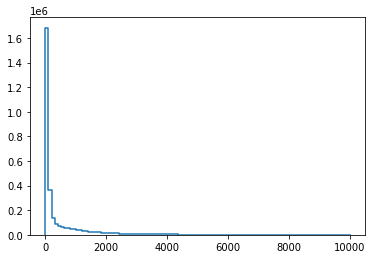

In [36]:
contents, bin_edges = cupy.histogram(inv_mass, cupy.linspace(0,10000,100, dtype=cupy.float32))
mplhep.histplot(cupy.asnumpy(contents), cupy.asnumpy(bin_edges))

Weighted histograms are not supported out of the box in `cupy`, so we create our own method. This also serves as a good example on how to use atomic operations.

In [37]:
@cuda.jit
def fill_histogram(
    data: numba.float32[:],
    weights: numba.float32[:],
    bins: numba.float32[:],
    out_w: numba.float32[:, :],
    out_w2: numba.float32[:, :]):
  
    assert(len(data) == len(weights))
    assert(len(bins)-1 == out_w.shape[1])
    assert(len(bins)-1 == out_w2.shape[1])

    xi = cuda.grid(1)
    xstride = cuda.gridsize(1)

    bi = cuda.blockIdx.x
    bd = cuda.blockDim.x
    ti = cuda.threadIdx.x
    
    nbins = out_w.shape[1]

    #loop over the data array 
    for i in range(xi, len(data), xstride):
        #numba.cuda does not support searchsorted, so we need to define our own method
        #bin_idx = np.searchsorted(bins, data[i])
        bin_idx = searchsorted_devfunc_right(bins, data[i]) - 1

        #put overflow in the last visible bin, as is typica for ROOT histograms
        if bin_idx >= nbins:
            bin_idx = nbins - 1

        #here we define a 2D index based on the block and bin 
        bin_idx_histo = (bi, bin_idx)

        if bin_idx >= 0 and bin_idx < nbins:
            wi = weights[i]
            #In order to prevent a race condition, we need to add the weights to the bin
            #contents atomically. As we use the block index as an additional temporary indexing dimension
            #for the histogram, threads can block each other only within the block.

            cuda.atomic.add(out_w, bin_idx_histo, wi)
            cuda.atomic.add(out_w2, bin_idx_histo, wi ** 2)

# Copied from numba source
@cuda.jit(device=True)
def searchsorted_inner_right(a, v):
    n = len(a)
    lo = np.int32(0)
    hi = np.int32(n)
    while hi > lo:
        mid = (lo + hi) >> 1
        if a[mid] <= v:
            # mid is too low => go up
            lo = mid + 1
        else:
            # mid is too high, or is a NaN => go down
            hi = mid
    return lo

@cuda.jit(device=True)
def searchsorted_devfunc_right(bins, val):
    ret = searchsorted_inner_right(bins, val)
    if val < bins[0]:
        ret = 0
    if val >= bins[len(bins) - 1]:
        ret = len(bins) - 1
    return ret

In [43]:
arr = cupy.random.randn(1000000, dtype=cupy.float32)
weights = cupy.ones_like(arr)

bins = cupy.linspace(-5,5, 100, dtype=cupy.float32)

nblocks = 128
nthreads = 1024
out_w = cupy.zeros((nblocks, len(bins) - 1), dtype=cupy.float32)
out_w2 = cupy.zeros((nblocks, len(bins) - 1), dtype=cupy.float32)

fill_histogram[nblocks, nthreads](arr, weights, bins, out_w, out_w2)
cuda.synchronize()

histo_w = cupy.asnumpy(out_w.sum(axis=0))
histo_w2 = cupy.asnumpy(out_w2.sum(axis=0))

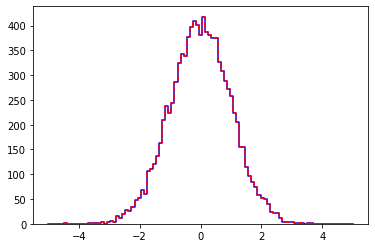

In [39]:
#Comparing the cupy and numpy histogram functions
mplhep.histplot(cupy.asnumpy(cupy.histogram(arr, bins=bins)[0]), cupy.asnumpy(bins), ls="-", color="blue")
mplhep.histplot(np.histogram(cupy.asnumpy(arr), bins=cupy.asnumpy(bins))[0], cupy.asnumpy(bins), ls="--", color="red")

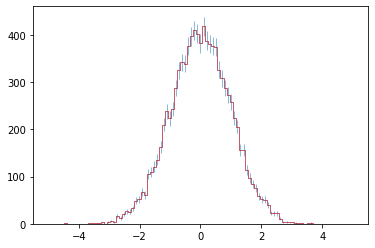

In [40]:
#Comparing our custom weighted histogram with numpy/cupy
mplhep.histplot(histo_w, cupy.asnumpy(bins), yerr=np.sqrt(histo_w2), lw=0.5)
mplhep.histplot(np.histogram(cupy.asnumpy(arr), bins=cupy.asnumpy(bins))[0], cupy.asnumpy(bins), ls="-", lw=0.5, color="red")

In [44]:
def test1():
  fill_histogram[nblocks, nthreads](arr, weights, bins, out_w, out_w2)
  cuda.synchronize()

%timeit test1()

1000 loops, best of 3: 1.12 ms per loop


In [45]:
arr_np = cupy.asnumpy(arr)
bins_np = cupy.asnumpy(bins)

%timeit np.histogram(arr_np, bins_np)

10 loops, best of 3: 70.8 ms per loop


# 6. Putting it together: Analysis Description Languages exercise 7.

Plot the sum of pT of jets with pT > 30 GeV that are not within 0.4 in ΔR of any lepton with pT > 10 GeV.

In [46]:
nblocks = 64
nthreads = 256

#This is a naive implementation and might result in thread divergence.
#Nevertheless, let's start here.
@cuda.jit(device=True)
def deltaphi_devfunc(phi1, phi2):
    dphi = phi1 - phi2
    out_dphi = 0
    if dphi > math.pi:
        dphi = dphi - 2 * math.pi
        out_dphi = dphi
    elif (dphi + math.pi) < 0:
        dphi = dphi + 2 * math.pi
        out_dphi = dphi
    else:
        out_dphi = dphi
    return out_dphi

#This kernel masks objects in the first collection based on proximity to the second
#collection.
@cuda.jit
def mask_deltar_first_cudakernel(
    etas1, phis1, mask1, offsets1, etas2, phis2, mask2, offsets2, dr2, mask_out
):
    xi = cuda.grid(1)
    xstride = cuda.gridsize(1)

    for iev in range(xi, len(offsets1) - 1, xstride):
        a1 = np.uint64(offsets1[iev])
        b1 = np.uint64(offsets1[iev + 1])

        a2 = np.uint64(offsets2[iev])
        b2 = np.uint64(offsets2[iev + 1])

        #loop over the first collection
        for idx1 in range(a1, b1):
            if not mask1[idx1]:
                continue

            eta1 = np.float32(etas1[idx1])
            phi1 = np.float32(phis1[idx1])

            #loop over the second collection
            for idx2 in range(a2, b2):
                if not mask2[idx2]:
                    continue

                eta2 = np.float32(etas2[idx2])
                phi2 = np.float32(phis2[idx2])

                deta = abs(eta1 - eta2)
                dphi = deltaphi_devfunc(phi1, phi2)

                passdr = (deta**2 + dphi**2) < dr2
                mask_out[idx1] = passdr

#This is the same as we had above, but includes a mask
@cuda.jit
def sum_in_offsets(offsets, content, mask_rows, mask_content, out):
    xi = cuda.grid(1)
    xstride = cuda.gridsize(1)

    for iev in range(xi, offsets.shape[0] - 1, xstride):
        if not mask_rows[iev]:
            continue

        start = offsets[iev]
        end = offsets[iev + 1]
        for ielem in range(start, end):
            if mask_content[ielem]:
                out[iev] += content[ielem]

In [47]:
jet_offsets = cupy.array(evs.array("Jet_pt").offsets)
jet_pt = cupy.array(evs.array("Jet_pt").content)
jet_eta = cupy.array(evs.array("Jet_eta").content)
jet_phi = cupy.array(evs.array("Jet_phi").content)
jet_mass = cupy.array(evs.array("Jet_mass").content)

mu_offsets = cupy.array(evs.array("Muon_pt").offsets)
mu_pt = cupy.array(evs.array("Muon_pt").content)
mu_eta = cupy.array(evs.array("Muon_eta").content)
mu_phi = cupy.array(evs.array("Muon_phi").content)

#Choose the passing muons and jets
mask_mu = mu_pt > 10.0
mask_jet = jet_pt > 30.0
mask_jet_dr = cupy.zeros(len(mask_jet), dtype=cupy.bool)

In [48]:
#Find which jets are closer than dR<0.4 to the muons
mask_deltar_first_cudakernel[nblocks, nthreads](
    jet_eta, jet_phi, mask_jet, jet_offsets,
    mu_eta, mu_phi, mask_mu, mu_offsets, 0.4**2, mask_jet_dr)
cuda.synchronize()

#Choose the final jets

 = mask_jet & ~mask_jet_dr

In [49]:
selected_jets

array([ True,  True,  True, ..., False, False, False])

In [51]:
#Now compute the sum pt
nev = len(jet_offsets) - 1
sum_pt = cupy.zeros(nev, dtype=cupy.float32)
sum_in_offsets[nblocks, nthreads](
    jet_offsets, jet_pt,
    cupy.ones(nev, dtype=cupy.bool),
    selected_jets,
    sum_pt)
cuda.synchronize()
sum_pt

array([98.553635,  0.      ,  0.      , ..., 39.726204,  0.      ,
       31.095316], dtype=float32)

In [52]:
#now fill the histogram
weights = cupy.ones(nev, dtype=cupy.float32)
bins = cupy.linspace(50, 500, 100, dtype=cupy.float32)
out_w = cupy.zeros((nblocks, len(bins) - 1), dtype=cupy.float32)
out_w2 = cupy.zeros((nblocks, len(bins) - 1), dtype=cupy.float32)

mask_events = sum_pt > 90.0

In [53]:
fill_histogram[nblocks, nthreads](sum_pt[mask_events], weights[mask_events], bins, out_w, out_w2)
cuda.synchronize()

hist_content = cupy.asnumpy(out_w.sum(axis=0))
hist_content2 = cupy.asnumpy(out_w2.sum(axis=0))
bins = cupy.asnumpy(bins)

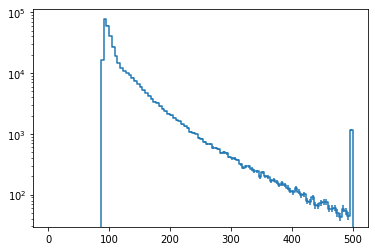

In [54]:
mplhep.histplot(hist_content, bins, yerr=np.sqrt(hist_content2))
plt.yscale("log")